# Visual Question Answering using Multimodal Transformer Models

In [25]:
from typing import Optional
from datasets import load_dataset
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments, BitsAndBytesConfig

In [26]:
MODEL_TEXT_ENCODER = "bert-base-uncased"
# MODEL_IMAGE_ENCODER = "google/vit-base-patch16-224-in21k"
MODEL_IMAGE_ENCODER = "microsoft/resnet-50"
MODEL_TEXT_GENERATOR = "gpt2"
OUT_MAX_LENGTH = 1
IN_MAX_LENGTH = 64

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce GTX 1660 Ti
Memory Usage:
Allocated: 3.2 GB
Cached:    4.9 GB


## Load VQAv2 Dataset

Dataset defined in VQAv2.py file. Auto downloaded in cache directory.

In [28]:
dataset = load_dataset('Dataset/VQAv2.py', name='v2', split='train[:10000]', cache_dir='/projects/.hf_datasets_cache/')
# generate test train split
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
test_dataset = dataset['test']

/home/shahlarious/miniconda3/envs/torch/lib/python3.11/site-packages/datasets/load.py:926: FutureWarning: The repository for VQAv2 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at Dataset/VQAv2.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [29]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'image'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'image'],
        num_rows: 2000
    })
})

In [30]:
dataset['train'][2]

{'question_type': 'what is the',
 'multiple_choice_answer': '70',
 'answers': [{'answer': '70', 'answer_confidence': 'maybe', 'answer_id': 1},
  {'answer': '67', 'answer_confidence': 'maybe', 'answer_id': 2},
  {'answer': '70', 'answer_confidence': 'maybe', 'answer_id': 3},
  {'answer': 'elderly', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': '75', 'answer_confidence': 'maybe', 'answer_id': 5},
  {'answer': '75', 'answer_confidence': 'maybe', 'answer_id': 6},
  {'answer': '65', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'sixty', 'answer_confidence': 'maybe', 'answer_id': 8},
  {'answer': 'elderly', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': '70', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 263875,
 'answer_type': 'number',
 'question_id': 263875001,
 'question': 'What is the age of this man?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x521>}

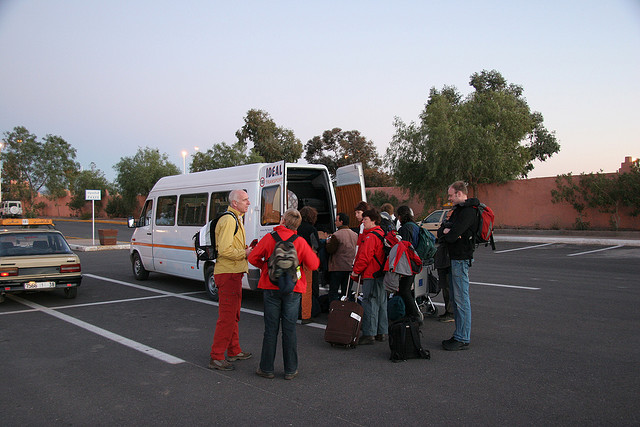

In [31]:
image = dataset['train'][0]['image']
image

In [32]:
def PIL_to_tensor(image):
    image = image.resize((224, 224))
    image = np.array(image)
    image = torch.tensor(image)
    # change the order of the channels
    image = image.permute(2, 0, 1)
    image = image.unsqueeze(0).float()
    return image

In [33]:
image = dataset['train'][0]['image']
print(PIL_to_tensor(image).shape)
# print max value of tensor
print(torch.max(PIL_to_tensor(image)))

torch.Size([1, 3, 224, 224])
tensor(255.)


In [34]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, input_tokenizer, output_tokenizer, out_max_length=OUT_MAX_LENGTH, input_max_length=IN_MAX_LENGTH):
        self.dataset = dataset
        self.input_tokenizer = input_tokenizer
        self.output_tokenizer = output_tokenizer
        self.input_max_length = input_max_length
        self.output_max_length = out_max_length
        self.output_tokenizer.pad_token = self.input_tokenizer.pad_token
        print(f"Set Output Tokenizer Pad Token to {self.input_tokenizer.pad_token} instead of {self.output_tokenizer.eos_token}")

    def __len__(self):
        return len(self.dataset)

    def _PIL_to_tensor(self, image):
        image = image.resize((224, 224))
        image = np.array(image)
        image = torch.tensor(image)
        # change the order of the channels
        try:
            image = image.permute(2, 0, 1)
        except:
            # image does not have 3 channels
            # duplicate the image to have 3 channels
            image = torch.stack([image, image, image], dim=0)
            print("Image does not have 3 channels")
            # print(image.shape)
            # raise Exception
        image = image.float()
        return image

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        image = self._PIL_to_tensor(image)
        question = item['question']
        question_tokens = self.input_tokenizer(item['question'], return_tensors='pt', max_length=self.input_max_length, padding='max_length', truncation=True)
        answer = item['answers'][0]['answer']
        answer_token = self.output_tokenizer(item['answers'][0]['answer'], return_tensors='pt', max_length=self.output_max_length, padding='max_length', truncation=True)
        inputs = {
            'pixel_values': image,
            'question': question,
            'answer': answer,
            **{key: value.squeeze(0) for key, value in question_tokens.items()},
            "decoder_input_ids": answer_token['input_ids'].squeeze(0)
        }
        return inputs

In [35]:
input_tokenizer = AutoTokenizer.from_pretrained(MODEL_TEXT_ENCODER)
output_tokenizer = AutoTokenizer.from_pretrained(MODEL_TEXT_GENERATOR)

In [36]:
train_vqa_dataset = VQADataset(train_dataset, input_tokenizer, output_tokenizer)
test_vqa_dataset = VQADataset(test_dataset, input_tokenizer, output_tokenizer)

Set Output Tokenizer Pad Token to [PAD] instead of <|endoftext|>
Set Output Tokenizer Pad Token to [PAD] instead of <|endoftext|>


In [37]:
train_loader = torch.utils.data.DataLoader(train_vqa_dataset, batch_size=4, shuffle=True)

In [38]:
for batch in train_loader:
    print(batch.keys())
    print(batch['pixel_values'].shape)
    print(batch['input_ids'].shape)
    print(batch['decoder_input_ids'].shape)
    break

dict_keys(['pixel_values', 'question', 'answer', 'input_ids', 'token_type_ids', 'attention_mask', 'decoder_input_ids'])
torch.Size([4, 3, 224, 224])
torch.Size([4, 64])
torch.Size([4, 1])


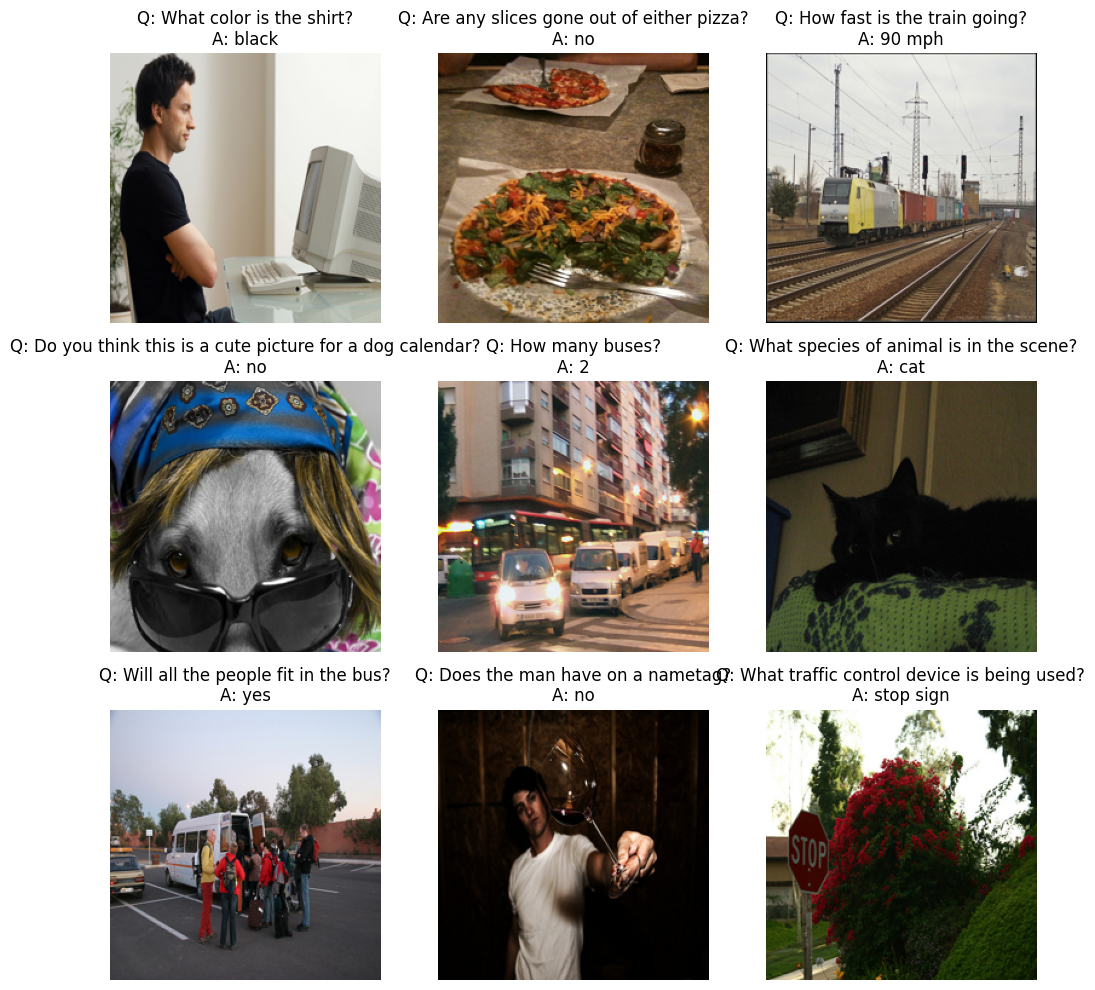

In [45]:
# show random examples in 3x3 grid

import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(train_vqa_dataset))
        item = train_vqa_dataset[idx]
        image = item['pixel_values']
        image = image.numpy().astype(np.uint8)
        # change the order of the channels
        image = np.transpose(image, (1, 2, 0))
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Q: {item['question']}\nA: {item['answer']}")
plt.tight_layout()
plt.show()


## Defining the Multimodal VQA Model Architecture

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            pretrained_text_name: str = MODEL_TEXT_ENCODER,
            pretrained_image_name: str = MODEL_IMAGE_ENCODER,
            pretrained_decoder_name: str = MODEL_TEXT_GENERATOR,
            intermediate_dim: int = 768):
     
        super(MultimodalVQAModel, self).__init__()
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        self.pretrained_decoder_name = pretrained_decoder_name
        # self.quantization_config = BitsAndBytesConfig(load_in_4bit=True)
        # self.quantization_config = QuantoConfig(weights="int8")
        self.quantization_config = None
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
            quantization_config=self.quantization_config
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
            quantization_config=self.quantization_config
        )
        self.text_decoder = AutoModelForCausalLM.from_pretrained(
            self.pretrained_decoder_name, 
            quantization_config=self.quantization_config
        )

        self.text_decoder.config.n_positions = OUT_MAX_LENGTH
        
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_sizes[-1], intermediate_dim),
            # nn.Linear(self.text_encoder.config.hidden_size + 1280, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            decoder_input_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        image_pooler_output = encoded_image['pooler_output']
        # reshape 
        image_pooler_output = image_pooler_output.view(1, -1)
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    image_pooler_output
                ],
                dim=1
            )
        )
        
        # Add fused output as prefix tokens to the decoder input
        decoder_input_embeds = self.text_decoder.transformer.wte(decoder_input_ids)
        prefix_embeds = fused_output.unsqueeze(1).expand(-1, decoder_input_embeds.size(1), -1)

        # print the shapes of the tensors
        # print(f"encoded_text: {encoded_text['pooler_output'].shape}")
        # print(f"encoded_image: {encoded_image['pooler_output'].shape}")
        # print(f"fused_output: {fused_output.shape}")
        # print(f"prefix_embeds: {prefix_embeds.shape}")
        # print(f"decoder_input_ids: {decoder_input_ids.shape}")
        decoder_input_embeds = torch.cat([prefix_embeds, decoder_input_embeds], dim=1)

        # print(f"decoder_input_embeds: {decoder_input_embeds.shape}")
        # labels = decoder_input_ids match the shape of decoder_input_embeds
        # extend with eos token
        labels = torch.cat([decoder_input_ids, torch.tensor([[decoder_input_ids] * decoder_input_ids.size(1)], device=device)], dim=1)
        # print(f"labels: {labels.shape}")
        
        decoder_outputs = self.text_decoder(
            inputs_embeds=decoder_input_embeds,
            labels=labels
        )
        print(f"Loss: {decoder_outputs.loss}")
        return decoder_outputs


### Define a Function to Create the Multimodal VQA Models along with their Collators

In [ ]:
def createMultimodalVQACollatorAndModel(text_encoder=MODEL_TEXT_ENCODER, image_encoder=MODEL_IMAGE_ENCODER, text_generator=MODEL_TEXT_GENERATOR):
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    multi_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=MultimodalVQAModel,
    )

    multi_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder,
        pretrained_decoder_name=text_generator
    ).to(device)

    return multi_collator, multi_model

## Model Training & Evaluation

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [ ]:
collator, model = createMultimodalVQACollatorAndModel()
exp = 1
batch_size = 1
epochs = 10
steps = int(len(train_vqa_dataset)/(batch_size*2))
multi_args = Seq2SeqTrainingArguments(
    output_dir=f"./trained/vqa_exp_{exp}",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=steps*0.01,
    weight_decay=0.01,
    logging_dir=f"./logs/vqa_exp_{exp}",
    logging_steps=steps,
    evaluation_strategy="steps",
    save_strategy="steps",
    predict_with_generate=True,
    save_total_limit=3,
    fp16=True,
    save_steps=steps,
    
)

multi_trainer = Seq2SeqTrainer(
    model=model,
    args=multi_args,
    train_dataset=train_vqa_dataset,
    eval_dataset=test_vqa_dataset,
    data_collator=collator,
    tokenizer=collator.tokenizer
)

In [ ]:
train_multi_metrics = multi_trainer.train()

In [ ]:
eval_multi_metrics = multi_trainer.evaluate()

In [ ]:
eval_multi_metrics

## Inference

In [ ]:
# model = MultimodalVQAModel()
data = train_vqa_dataset[134]
q = data.pop('question')
a = data.pop('answer')
print(q)
print(a)
for key, value in data.items():
    data[key] = value.unsqueeze(0)

data['pixel_values'] = data['pixel_values']
# device = 'cpu'
# put the data on the device
data = {key: value.to(device) for key, value in data.items()}
# check device of the model
model = model.to(device)
output = model(**data)
output_tokens = output["logits"].argmax(axis=-1).cpu().numpy()
print(output_tokens)
# decode the output tokens
output_text = output_tokenizer.decode(output_tokens[0], skip_special_tokens=True)
print(output_text)